In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
# plt.rcParams.update({'font.size': 22})
from PIL import Image
import importlib
import os
import sys

import lasso;from lasso import *
importlib.reload(lasso);from lasso import *
from forward_model import *
from mask import *
import utils
from physical_params import *
sys.path.append("../Curvelab/fdct3d/src/")

In [2]:
N = 256
NZ = 10
data_dir = "../data/"
num_masks = 10

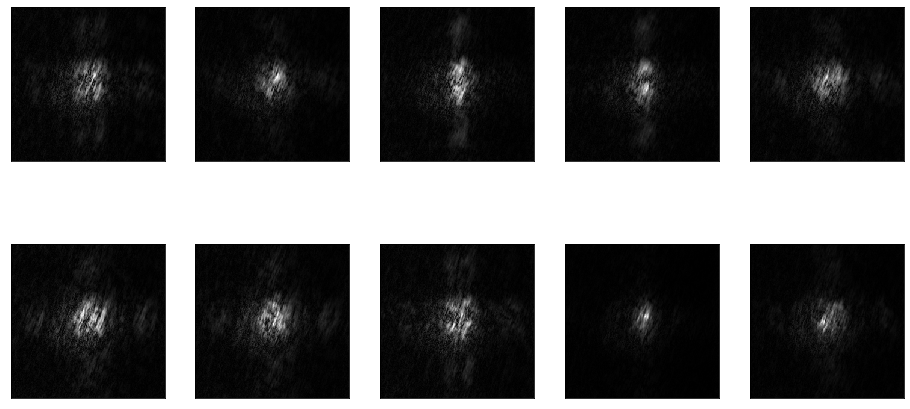

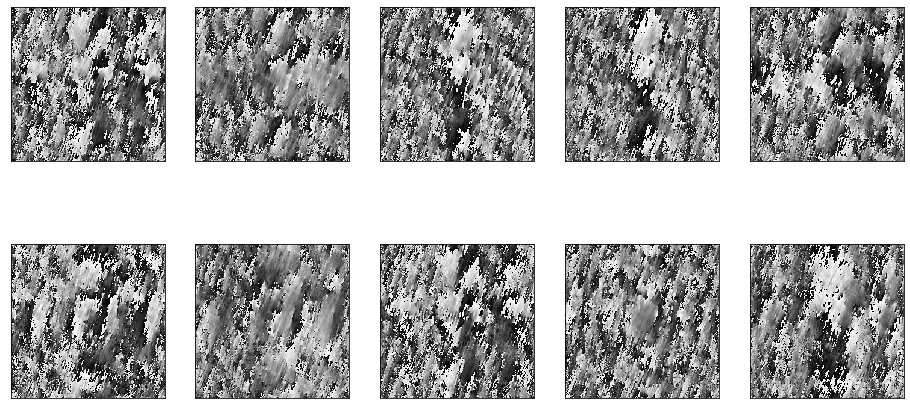

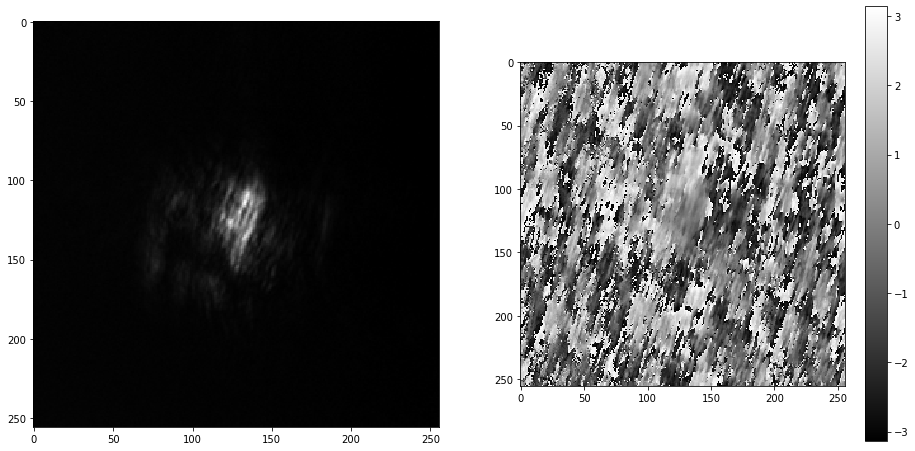

In [3]:
# get data
y_meas = np.load("../results/ReconCpxField_meas.npy")
y_holo = np.load("../results/ReconCpxField_rplane.npy")

# Normalize data
y_meas = y_meas / abs(y_holo).max()
y_holo = y_holo / abs(y_holo).max()

# plot the magnitude of the complex measurements
plt.rcParams['figure.figsize'] = 16,8
plt.figure(1)
for i in range(y_meas.shape[0]):
    plt.subplot(2,5,i+1)
    plt.imshow(abs(y_meas[i,:,:]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.figure(2)
for i in range(y_meas.shape[0]):
    plt.subplot(2,5,i+1)
    plt.imshow(np.angle(y_meas[i,:,:]), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.figure(3)
plt.subplot(121)
plt.imshow(abs(y_holo), cmap='gray')
plt.subplot(122)
plt.imshow(np.angle(y_holo), cmap='gray');plt.colorbar()

In [4]:
# load masks from mask files
mask_filenames = []
mask_dir = data_dir+"tissue/maskth/"
for file in os.listdir(mask_dir):
    if file.endswith(".tif"):
        mask_filenames += [mask_dir+file]

mask = masks(num_masks, (N,N))

assert len(mask_filenames)==num_masks, "Number of masks does not match number of files"
mask.get_mask(mask_filenames)
# rescale mask between -1 and 1
mask.value = 2 * (mask.value/255.) - 1
mask.value = -mask.value

In [17]:
# Construct forward model
input_shape = (N,N,NZ)
fwd_op = ForwardModel(input_shape, mask, defocus=-LZ, include_shg=True)

In [ ]:
solver = LassoSolver(fwd_op, use_fista=False)
# x_init = fwd_op.adjoint(y_meas)/mask.num/NZ
x_init = holographic_recon(fwd_op.uscope, y_holo)
# xest,_,_ = solver.solve_fista(y_meas, n_iter=100,
#                    sparsifying="curvelets",
#                    print_recon=False,
#                    ground_truth=None)
xest = solver.solve_ista(y_meas,
                        x_init=x_init,
                        step=1.e-2,
                        lam=1.e-1,
                        imag_reg=0.0,
                        n_iter=500,
                        step_scheduling=0.9999,
                        reg_scheduling=0.9999,
                        sparsifying="curvelets",
                        print_recon=False,
                        ground_truth=None)

Iter : 0 , MSE : 0.0014931187045994923
Iter : 10 , MSE : 0.0013900698088581695
Iter : 20 , MSE : 0.0013899945697790248
Iter : 30 , MSE : 0.0013899933575755798
Iter : 40 , MSE : 0.0013899932466333728
Iter : 50 , MSE : 0.001389993225354091


In [1]:
# Try different constant phase factors during reconstruction.
# xests = []
# final_losses = []
# const_phases = np.arange(10)*np.pi/10.

# for idx, phi0 in enumerate(const_phases):
#     print(idx, " : ", phi0)
#     xest = solver.solve_ista(y_meas*utils.cis(phi0),
#                             x_init=x_init,
#                             step=1.e-2,
#                             lam=1.e-3,
#                             n_iter=100,
#                             step_scheduling=0.9999,
#                             reg_scheduling=0.995,
#                             sparsifying="curvelets",
#                             print_recon=False,
#                             ground_truth=None)
#     xests.append(xest)
#     final_losses.append(solver.final_mse)
    

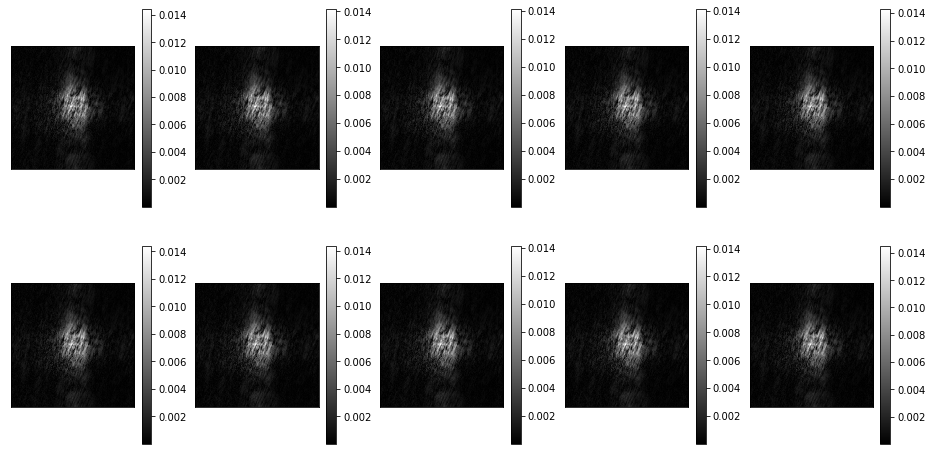

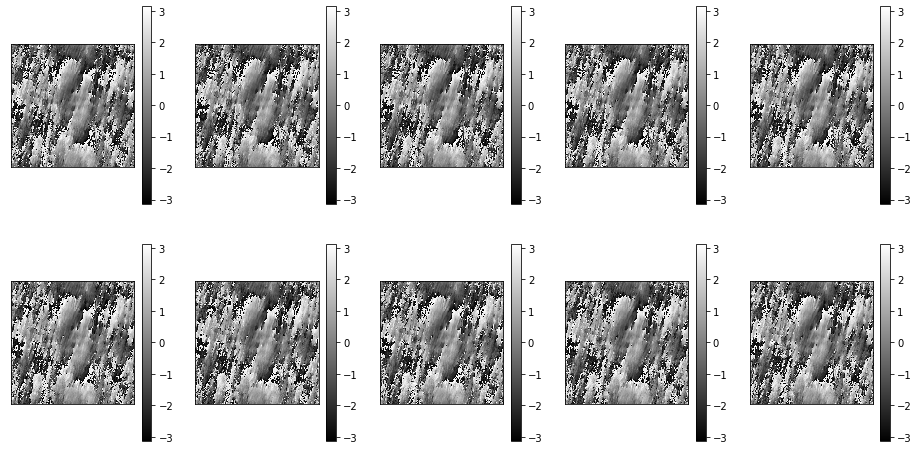

In [32]:
# plot the reconstructed tissue
plt.rcParams['figure.figsize'] = 16,8
plt.figure(1)
for i in range(xest.shape[2]):
    plt.subplot(2,5,i+1)
    plt.imshow(abs(xest[:,:,i]), cmap='gray');plt.colorbar()
    plt.xticks([])
    plt.yticks([])
plt.figure(2)
for i in range(xest.shape[2]):
    plt.subplot(2,5,i+1)
    plt.imshow(np.angle(xest[:,:,i]), cmap='gray');plt.colorbar()
    plt.xticks([])
    plt.yticks([])


In [25]:
xhol = holographic_recon(fwd_op.uscope, y_holo)

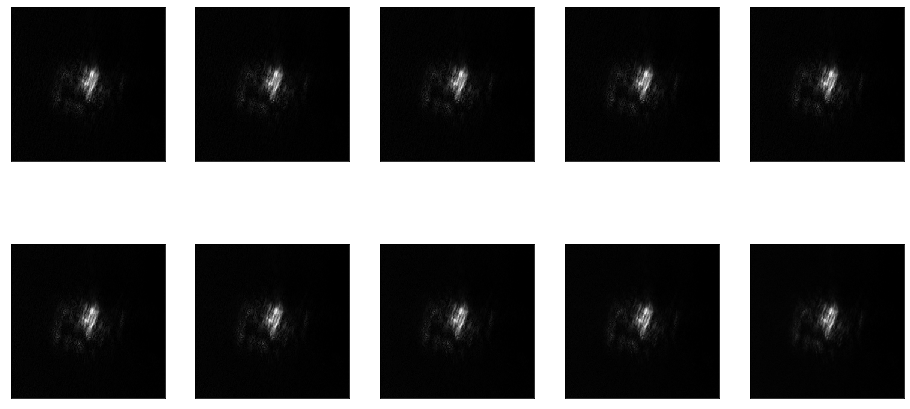

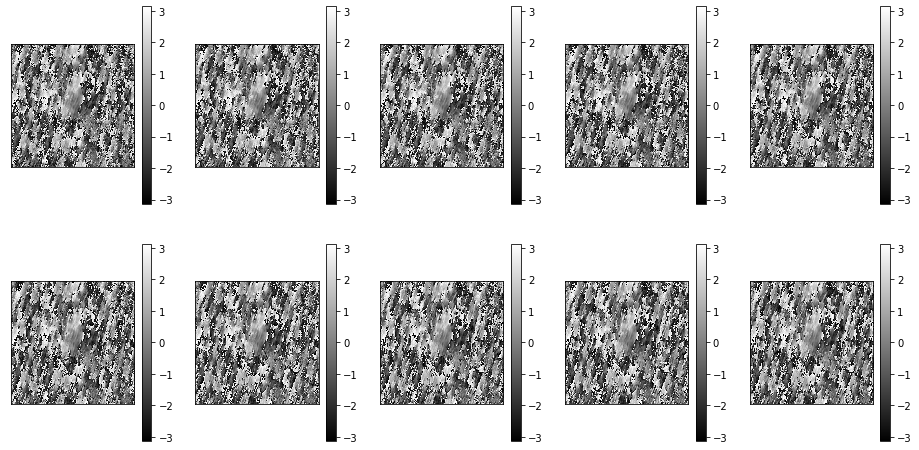

In [26]:
plt.rcParams['figure.figsize'] = 16,8
plt.figure(1)
for i in range(xhol.shape[2]):
    plt.subplot(2,5,i+1)
    plt.imshow(abs(xhol[:,:,i]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.figure(2)
for i in range(xest.shape[2]):
    plt.subplot(2,5,i+1)
    plt.imshow(np.angle(xhol[:,:,i]), cmap='gray');plt.colorbar()
    plt.xticks([])
    plt.yticks([])

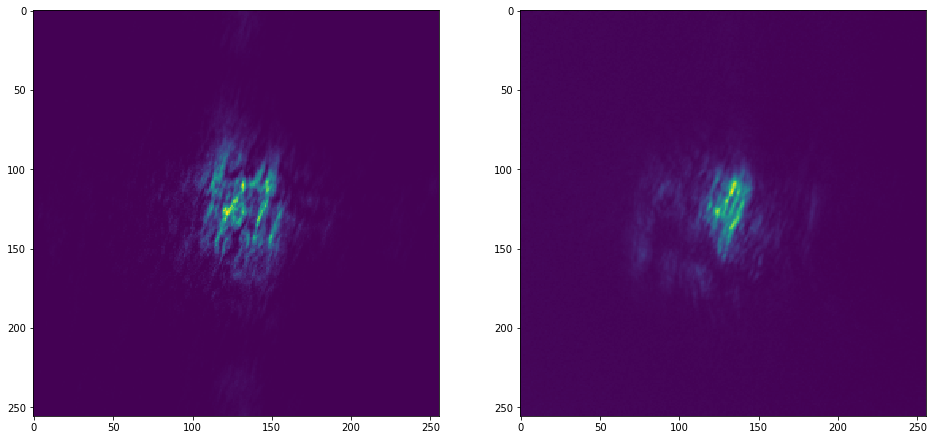

In [19]:
plt.subplot(121)
plt.imshow(abs(fwd_op.fourf.adjoint(y_meas))**2)
plt.subplot(122)
plt.imshow(abs(y_holo))

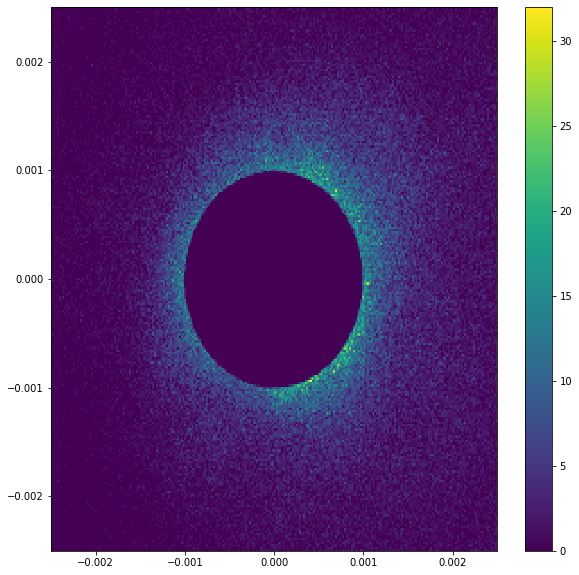

In [29]:
plt.rcParams['figure.figsize'] = 10,10
plt.hist2d(xest[abs(xest)>0.001].real.flatten(), xest[abs(xest)>0.001].imag.flatten(), bins=1000);
plt.xlim([-0.0025, 0.0025])
plt.ylim([-0.0025, 0.0025])
plt.colorbar()